In [1]:
# Resset notebook. There were problems running Merlin Models.
# It is always important to completely reboot the system between runs.
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# Opening required packages for processing with set seed
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1-"  # "-1" for none
#os.environ.pop('TF_CONFIG', None)
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

import pandas as pd
pd.set_option('max_colwidth', None)

import numpy as np
np.random.seed(76)

import tensorflow as tf
tf.random.set_seed(76)
tf.keras.utils.set_random_seed(76)  

import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Opening required packages to show output
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
# Opening merlin models with nvtabular support
import nvtabular as nvt
from nvtabular.ops import *

import merlin.models.tf as mm
from merlin.schema.tags import Tags
from merlin.io.dataset import Dataset

In [4]:
# Preprocessing data hyperparameters
MIN_ITEM_RATINGS = 8     # optional minimum value
MIN_USER_RATINGS = 10    # optional minimum value
THRESHOLD = 3.0          # True IF Rating value >= THRESHOLD, else False
MIN_SESSION_LENGTH = 2
MAX_SESSION_LENGTH = 10

# X-Wines Data Preprocessing steps----------------

In [5]:
# Opening Slim X-Wines dataset
wines = pd.read_csv("Data/XWines_Slim_1K_wines.csv", low_memory=False, encoding="utf-8", memory_map=True)
ratings = pd.read_csv("Data/XWines_Slim_150K_ratings.csv", low_memory=False, encoding="utf-8", memory_map=True)
len(wines), len(ratings)

(1007, 150000)

In [6]:
print("Total wines:", wines.WineID.nunique(), "from", wines.Code.nunique(), "different countries")
print("Total users:", ratings.UserID.nunique(), f"who rated the wines in the period between {ratings.Date.min()} and {ratings.Date.max()}")
print("Total ratings:", len(ratings), f"5-stars on wine vintages since {ratings.Vintage.min()}, including non-vintage 'N.V.'")

Total wines: 1007 from 31 different countries
Total users: 10561 who rated the wines in the period between 2012-04-19 20:46:00 and 2021-12-31 23:58:52
Total ratings: 150000 5-stars on wine vintages since 1950, including non-vintage 'N.V.'


In [7]:
# Vertical cut-off point for training and test on the most relevant data
wineRatings = ratings.groupby(['WineID'], as_index=False)['Rating'].count()
wineRatings = wineRatings[wineRatings.Rating >= MIN_ITEM_RATINGS]
collabRatings = ratings[ratings.WineID.isin(wineRatings.WineID.values)]

userRatings = collabRatings.groupby('UserID', as_index=False)['Rating'].count()
userRatings = userRatings[userRatings.Rating >= MIN_USER_RATINGS]
collabRatings = collabRatings[collabRatings.UserID.isin(userRatings.UserID.values)]

collabWines = wines[wines.WineID.isin(collabRatings.WineID.unique())]

del wineRatings, userRatings
gc.collect()

print(collabWines.shape, 'useful wines for collaborative filtering')
print(collabRatings.shape, 'useful ratings for collaborative filtering')

(894, 17) useful wines for collaborative filtering
(133278, 6) useful ratings for collaborative filtering


In [8]:
# Horizontal cut-off point for training and test on the most relevant data
collabWines = collabWines[['WineID', 'WineName', 'Type', 'Code']].reset_index(drop=True)
collabRatings = collabRatings[['UserID', 'WineID', 'Vintage', 'Rating', 'Date']].reset_index(drop=True)

print(collabWines.shape, 'useful wines for collaborative filtering')
print(collabRatings.shape, 'useful ratings for collaborative filtering')
print(collabRatings.WineID.nunique(), 'wines    ', collabRatings.UserID.nunique(),'users',
      '  consistency wine x ratings:', sorted(collabWines.WineID.unique())==sorted(collabRatings.WineID.unique()))

(894, 4) useful wines for collaborative filtering
(133278, 5) useful ratings for collaborative filtering
894 wines     8369 users   consistency wine x ratings: True


In [9]:
# Types definition
collabWines = collabWines.sort_values(by=['WineID'])
collabWines.WineID = collabWines.WineID.astype(int)
collabWines.WineName = collabWines.WineName.astype(str)
collabWines.Type = collabWines.Type.astype(str)
collabWines.Code = collabWines.Code.astype(str)
collabWines.dtypes

WineID       int32
WineName    object
Type        object
Code        object
dtype: object

In [10]:
import datetime as dt
import time

def DateToUnixTime(d = '0000-00-00 00:00:00'):
    return (int(time.mktime(dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').timetuple())) ) #// 3600 // 24)

collabRatings.UserID = collabRatings.UserID.astype(int)
collabRatings.WineID = collabRatings.WineID.astype(int)
collabRatings.Vintage = collabRatings.Vintage.astype(str)
collabRatings.Rating = collabRatings.Rating.astype('float32')
# choose date format
#collabRatings.Rating = collabRatings.Rating.apply(lambda x: 0 if (x<THRESHOLD) else 1).astype(np.int16)
# Date format possibilities:
#collabRatings.Date = pd.Series(collabRatings.Date, dtype="datetime64[ns]")           # all Y-M-D H:m:s
#collabRatings.Date = collabRatings.Date.apply(lambda x: pd.Timestamp(str(x)[:10]))   # only Y-M-D
collabRatings.Date = collabRatings.Date.apply(lambda x: DateToUnixTime(x))     # integer date
collabRatings.Date = collabRatings.Date.astype(int)

collabRatings.dtypes

UserID       int32
WineID       int32
Vintage     object
Rating     float32
Date         int32
dtype: object

In [11]:
collabRatings = pd.merge(collabRatings, collabWines[['WineID', 'Type', 'Code']], how="left", on=['WineID'])
#collabRatings['Match'] = (collabRatings.Type == collabRatings.Type.shift())
collabRatings = collabRatings.rename(columns={'WineID': 'ItemID', 'Type':'Category'})
collabRatings.shape, collabRatings.dtypes

((133278, 7),
 UserID        int32
 ItemID        int32
 Vintage      object
 Rating      float32
 Date          int32
 Category     object
 Code         object
 dtype: object)

In [12]:
collabRatings

,UserID,ItemID,Vintage,Rating,Date,Category,Code
0,1356810,103471,1950,4.5,1635897179,Dessert/Port,PT
1,1173759,111415,1951,5.0,1440103586,Red,FR
2,1164877,111395,1952,5.0,1605256826,Red,FR
3,1207665,111433,1953,5.0,1493977453,Red,FR
4,1075841,111431,1955,5.0,1473895118,Red,FR
...,...,...,...,...,...,...,...
133273,1000052,111468,N.V.,4.5,1640217831,Sparkling,FR
133274,1180844,111461,N.V.,4.0,1492992475,Sparkling,FR
133275,1218581,113690,N.V.,3.5,1555274708,Sparkling,FR
133276,1106198,111468,N.V.,4.5,1625911215,Sparkling,FR


In [13]:
def lastUserIndexes(DF):   # last MAX_SESSION_LENGTH sequence for each user
    df = DF.copy()
    df = df.sort_values(['UserID', 'Date'])
    for i in range(MAX_SESSION_LENGTH):
        df = df.loc[df.index.difference(df.drop_duplicates(subset=['UserID'], keep='last').index)]
    return (DF.loc[DF.index.difference(df.index)].sort_values(['UserID', 'Date']).reset_index(drop=True))

In [14]:
# train and test split for nextItem
collabRatings = collabRatings.sort_values(by=['UserID', 'Date']).reset_index(drop=True)
testDF0 = collabRatings.drop_duplicates(subset=['UserID'], keep='last')
trainDF0 = collabRatings.loc[collabRatings.index.difference(testDF0.index)].sort_values(by=['UserID', 'Date']).reset_index(drop=True)
testDF0 = testDF0.sort_values(by=['UserID', 'Date']).reset_index(drop=True)

trainDF = trainDF0.copy()
testDF = lastUserIndexes(collabRatings)   #last MAX_SESSION_LENGTH for each user sequence

trainDF0.shape, testDF0.shape, trainDF.shape, testDF.shape

((124909, 7), (8369, 7), (124909, 7), (83690, 7))

In [15]:
'Items check:', collabRatings.ItemID.nunique(), trainDF.ItemID.nunique(), testDF0.ItemID.nunique(), sorted(collabRatings.ItemID.unique()) == sorted(trainDF.ItemID.unique())  # same items for categorify

('Items check:', 894, 894, 728, True)

In [16]:
'Users check:', collabRatings.UserID.nunique(), trainDF.UserID.nunique(), testDF.UserID.nunique(), \
sorted(collabRatings.UserID.unique()) == sorted(trainDF.UserID.unique()) == sorted(testDF.UserID.unique())      # same users for categorify

('Users check:', 8369, 8369, 8369, True)

In [ ]:
# Optional
#SLICEDATE = "2021-01-01"
#trainDF = collabRatings[(collabRatings.Date < pd.Timestamp(SLICEDATE))]
#testDF = collabRatings[(collabRatings.Date >= pd.Timestamp(SLICEDATE))]
#trainDF.shape, testDF.shape

In [17]:
# Writing!!! # Optional
collabRatings.to_csv("Data/slimCollabRatings.csv", index=False)
trainDF.to_csv("Data/slimTrainDF.csv", index=False)
testDF.to_csv("Data/slimTestSeqDF.csv", index=False)
testDF0.to_csv("Data/slimTestDF.csv", index=False)

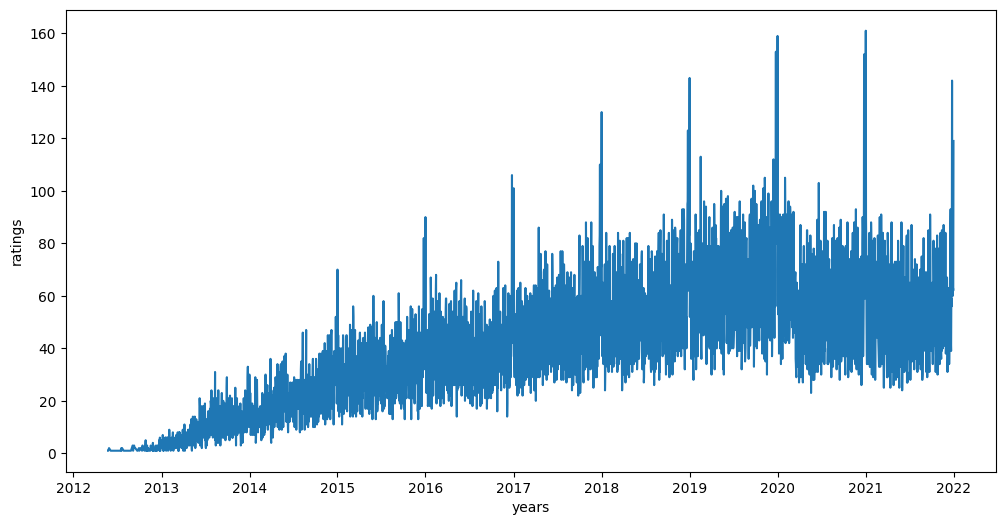

In [18]:
# graph !!! # Optional
import datetime as dt

collabGraph = collabRatings.copy()
collabGraph.Date = collabGraph.Date.apply(lambda x: dt.date.fromtimestamp(x))
collabGraph.groupby(['Date']).size().sort_index().plot.line(figsize=(12, 6), xlabel="years", ylabel="ratings")
plt.show()

In [19]:
# n wines x date x user   # Optional
def frequency(my_list):
    freq = {}
    for item in np.unique(np.array(my_list)):
        freq[item] = np.where(np.array(my_list) == item)[0].shape[0]
    return freq

freq = frequency(collabGraph.groupby(['ItemID', 'Date'])['ItemID'].count().sort_values().to_list())
print('same day ratings x quantity')
for key, value in freq.items():
    print(" % d : % d" % (key, value))

same day ratings x quantity
  1 :  109608
  2 :  9661
  3 :  1138
  4 :  160
  5 :  32
  6 :  10
  7 :  6
  9 :  1
  10 :  1
  13 :  1


In [20]:
# garbage # Optional
del collabGraph, freq, key, value
gc.collect()

4043

In [21]:
# check input data # Optional

In [22]:
testDF.duplicated(subset=['UserID', 'Date', 'ItemID']).sum()

0

In [23]:
testDF.duplicated(subset=['UserID', 'Date', 'ItemID']).sum()

0

In [24]:
trainDF.groupby('UserID')['Date'].size().describe()

count    8369.000000
mean       14.925200
std         6.743625
min         9.000000
25%        10.000000
50%        13.000000
75%        17.000000
max        66.000000
Name: Date, dtype: float64

In [25]:
trainDF.groupby('UserID')['ItemID'].size().describe()

count    8369.000000
mean       14.925200
std         6.743625
min         9.000000
25%        10.000000
50%        13.000000
75%        17.000000
max        66.000000
Name: ItemID, dtype: float64

In [26]:
del collabRatings, collabWines, wines, ratings
gc.collect()

0

# Movie Data  Preprocessing steps --------------

In [ ]:
users = pd.read_csv("Data/ml-1m/users.dat", sep="::", names=["user_id", "sex", "age_group", "occupation", "zip_code"])
ratings = pd.read_csv("Data/ml-1m/ratings.dat", sep="::", names=["user_id", "movie_id", "rating", "unix_timestamp"])
movies = pd.read_csv("Data/ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"])
len(users), len(ratings), len(movies)

In [ ]:
ratings = ratings.rename(columns={'user_id': 'UserID', 'movie_id': 'ItemID', 'rating': 'Rating', 'unix_timestamp': 'Date'})
#import datetime as dt
#ratings.Date = ratings.Date.apply(lambda x: dt.date.fromtimestamp(x))
ratings

In [ ]:
movies = movies.rename(columns={'movie_id': 'ItemID', 'title': 'ItemName', 'genres': 'Category'})
movies.Category = movies.Category.apply(lambda x: list(str(x).split('|'))[0])
movies

In [ ]:
# Vertical cut-off point for training and test on the most relevant data
movieRatings = ratings.groupby(['ItemID'], as_index=False)['Rating'].count()
movieRatings = movieRatings[movieRatings.Rating >= MIN_ITEM_RATINGS]
ratings = ratings[ratings.ItemID.isin(movieRatings.ItemID.values)]

userRatings = ratings.groupby('UserID', as_index=False)['Rating'].count()
userRatings = userRatings[userRatings.Rating >= MIN_USER_RATINGS]
ratings = ratings[ratings.UserID.isin(userRatings.UserID.values)]

movies = movies[movies.ItemID.isin(ratings.ItemID.unique())]

del movieRatings, userRatings
gc.collect()

print(movies.shape, 'useful movies for collaborative filtering')
print(ratings.shape, 'useful ratings for collaborative filtering')

In [ ]:
collabRatings = pd.merge(ratings, movies[['ItemID', 'Category']], how="left", on=['ItemID'])
collabRatings.UserID = collabRatings.UserID.astype(int)
collabRatings.ItemID = collabRatings.ItemID.astype(int)
collabRatings.Date = collabRatings.Date.astype(int)
collabRatings.Rating = collabRatings.Rating.astype('float32')

del movies, ratings, users
gc.collect()

collabRatings.dtypes

In [ ]:
def lastUserIndexes(DF):   # last MAX_SESSION_LENGTH sequence for each user
    df = DF.copy()
    df = df.sort_values(['UserID', 'Date'])
    for i in range(MAX_SESSION_LENGTH):
        df = df.loc[df.index.difference(df.drop_duplicates(subset=['UserID'], keep='last').index)]
    return (DF.loc[DF.index.difference(df.index)].sort_values(['UserID', 'Date']).reset_index(drop=True))

In [ ]:
collabRatings = collabRatings.sort_values(by=['UserID', 'Date']).reset_index(drop=True)
# Last rating from each user to test data
testDF0 = collabRatings.drop_duplicates(subset=['UserID'], keep='last')
trainDF0 = collabRatings.loc[collabRatings.index.difference(testDF0.index)].sort_values(by=['UserID', 'Date']).reset_index(drop=True)
testDF0 = testDF0.sort_values(by=['UserID', 'Date']).reset_index(drop=True)

trainDF = trainDF0.copy()
testDF = lastUserIndexes(collabRatings)   #last MAX_SESSION_LENGTH for each user sequence

trainDF0.shape, testDF0.shape, trainDF.shape, testDF.shape

In [ ]:
'Items check:', collabRatings.ItemID.nunique(), trainDF.ItemID.nunique(), testDF0.ItemID.nunique(), sorted(collabRatings.ItemID.unique()) == sorted(trainDF.ItemID.unique())  # same items for categorify

In [ ]:
'Users check:', collabRatings.UserID.nunique(), trainDF.UserID.nunique(), testDF.UserID.nunique(), \
sorted(collabRatings.UserID.unique()) == sorted(trainDF.UserID.unique()) == sorted(testDF.UserID.unique())      # same users for categorify

In [ ]:
# optional graph
import datetime as dt

collabGraph = collabRatings.copy()
collabGraph.Date = collabGraph.Date.apply(lambda x: dt.date.fromtimestamp(x))
collabGraph.groupby(['Date']).size().sort_index().plot.line(figsize=(12, 6), xlabel="years", ylabel="ratings")
plt.show()

In [ ]:
# n movies x date x user   # Optional
def frequency(my_list):
    freq = {}
    for item in np.unique(np.array(my_list)):
        freq[item] = np.where(np.array(my_list) == item)[0].shape[0]
    return freq

freq = frequency(collabGraph.groupby(['ItemID', 'Date'])['ItemID'].count().sort_values().to_list())
print('same day ratings x quantity')
for key, value in freq.items():
    print(" % d : % d" % (key, value))

In [ ]:
# garbage # Optional
del collabGraph, freq, key, value
gc.collect()

In [ ]:
# Writing!!! # optional
collabRatings.to_csv("Data/movieCollabRatings.csv", index=False)
trainDF.to_csv("Data/movieTrainDF.csv", index=False)
testDF.to_csv("Data/movieTestSeqDF.csv", index=False)
testDF0.to_csv("Data/movieTestDF.csv", index=False)

In [ ]:
del collabRatings
gc.collect()

# Model DTP Modeling steps --------------------

In [27]:
# opening selected pandas dataframe previously selected for modeling
datasetName = 'X-Wines_Slim'
#datasetName = 'MovieLens_1M'

if datasetName == 'X-Wines_Slim':
    trainDF0 = pd.read_csv("Data/slimTrainDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    testDF0  = pd.read_csv("Data/slimTestDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    
    trainDF = trainDF0.copy()
    testDF  = pd.read_csv("Data/slimTestSeqDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    print(trainDF0.shape, testDF0.shape, 'with last sequence:', trainDF.shape, testDF.shape)
elif datasetName == 'MovieLens_1M':
    trainDF0 = pd.read_csv("Data/movieTrainDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    testDF0  = pd.read_csv("Data/movieTestDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    
    trainDF = trainDF0.copy()
    testDF  = pd.read_csv("Data/movieTestSeqDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    print(trainDF0.shape, testDF0.shape, 'with last sequence:', trainDF.shape, testDF.shape)    
else:
    print('Dataset inconsistency!!!')

(124909, 7) (8369, 7) with last sequence: (124909, 7) (83690, 7)


In [28]:
# pandas dataframe to merlin dataset
train = Dataset(trainDF)
test  = Dataset(testDF)

In [29]:
# data modeling to sequences
ItemIDCategory = ['ItemID'] >> Categorify()  # 0, 1 and 2 are reserved indexes
TypeCategory = ['Category'] >> Categorify()
RatingCategory = (
    ["Rating"]
    >> LambdaOp(lambda col: (col >= THRESHOLD))
    >> Categorify()
    >> Rename(name='binaryRating')
)

features = ['UserID', 'Date'] + ItemIDCategory + TypeCategory + RatingCategory
groupbyFeatures = (
    features
    >> Groupby(
        groupby_cols=['UserID'],   
        sort_cols=['Date'],
        aggs={
            'ItemID': ['list', 'count', 'last'], 
            'Category': ['list'],
            'binaryRating': ['list'],
        }
    )
)

featuresItem = (
    groupbyFeatures['ItemID_list']
    >> AddTags([Tags.ITEM, Tags.ITEM_ID, Tags.SEQUENCE])
)
featuresType = (
    groupbyFeatures['Category_list']
    >> AddTags([Tags.SEQUENCE])
)
featuresRating = (
    groupbyFeatures['binaryRating_list']
    >> AddTags([Tags.SEQUENCE])
)

def computeDTPSequence(col):
    column = []
    for i in col.items():
        sequence = []
        types = list(i[1])
        previous = -1
        for now in types:
            sequence.append(previous != now)
            previous = now
        column.append(sequence)
    return column

featuresDTPSequence = (
    featuresType
    >> LambdaOp(lambda col: computeDTPSequence(col))
    >> Categorify()   
    >> Rename(name='DTPSequence_list')
)
truncatedFeatures = (
    (featuresItem + featuresType + featuresRating + featuresDTPSequence)
    >> ListSlice(-MAX_SESSION_LENGTH)
)
Sessions = (
    groupbyFeatures['UserID', 'ItemID_count'] + truncatedFeatures
    >> Filter(f=lambda df: df["ItemID_count"] >= MIN_SESSION_LENGTH)
)
itemCountSession = (
    Sessions['ItemID_count']
    >> NormalizeMinMax()
    >> AddTags([Tags.CONTEXT,Tags.CONTINUOUS])
    >> Rename(name="itemCountSession")
)

inputsFlow = Sessions['UserID', 'ItemID_list', 'Category_list', 'binaryRating_list', 'DTPSequence_list'] + itemCountSession

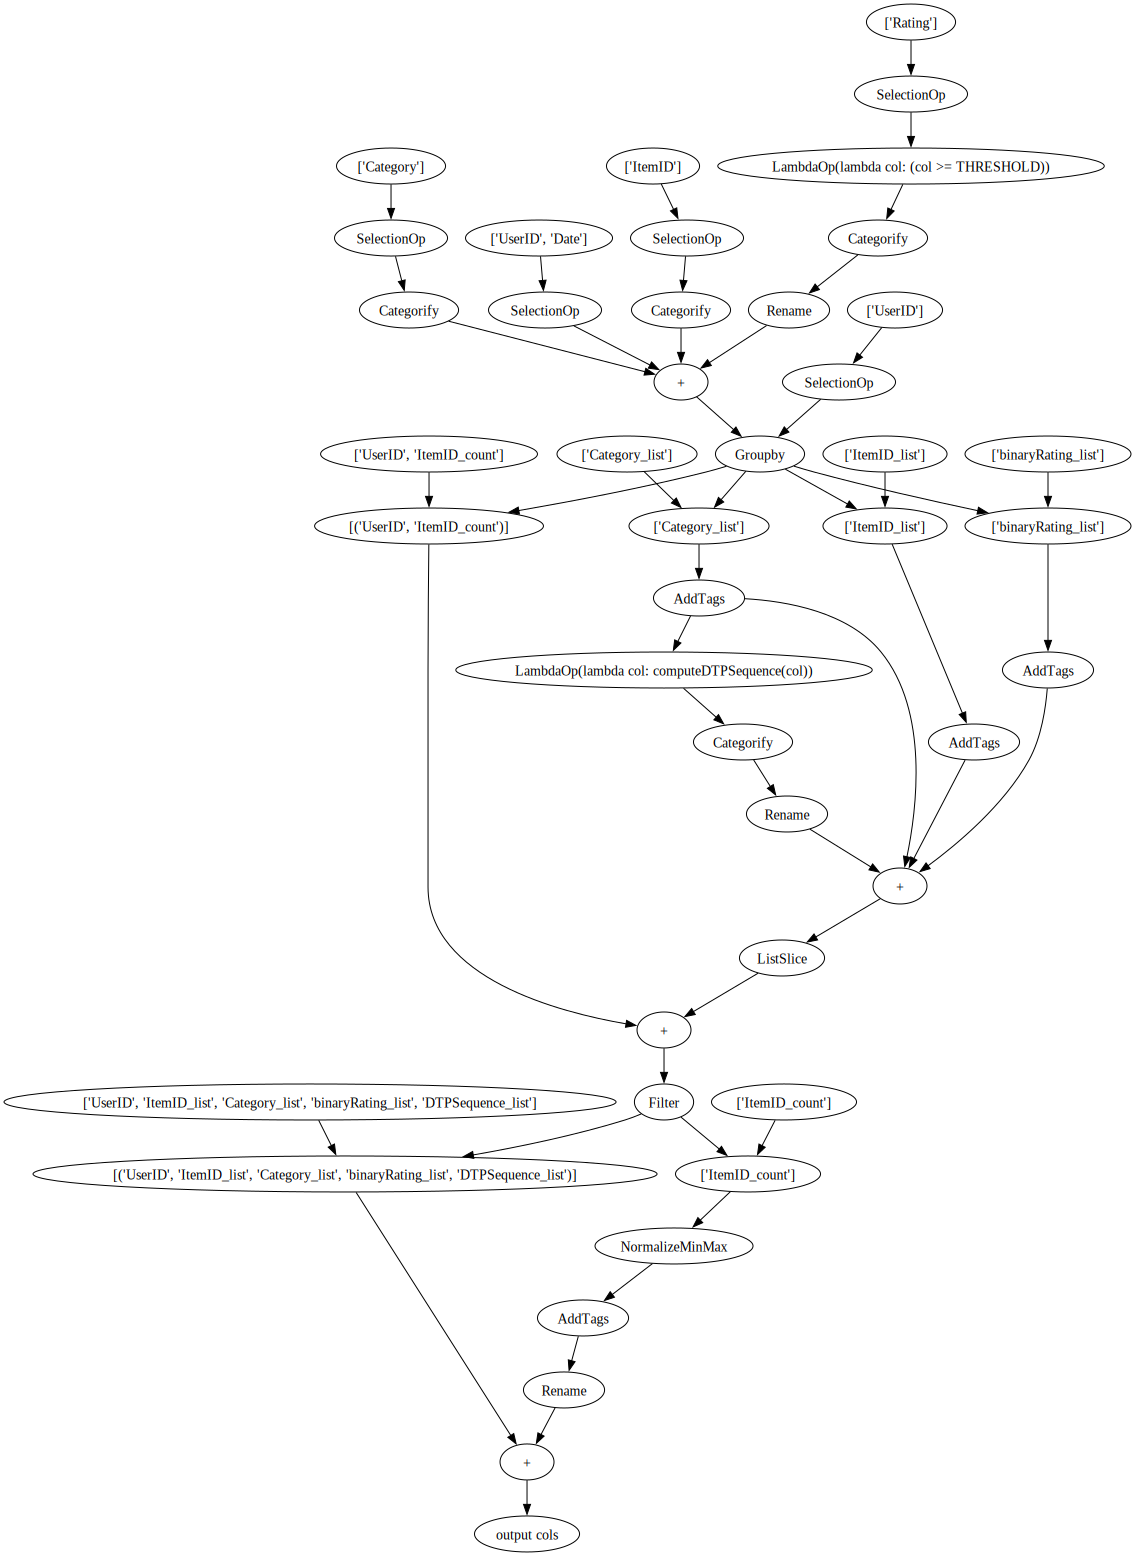

In [30]:
inputsFlow.graph

In [31]:
workflow = nvt.Workflow(inputsFlow)
# calculate statistics on the training dataset
workflow = workflow.fit(train)
# applies the transformation to training and testing dataset
trainFlow = workflow.transform(train)
testFlow = workflow.transform(test)

In [32]:
# check transform data
train.num_rows, test.num_rows, 'to sequences ==>', trainFlow.num_rows, testFlow.num_rows

(124909, 83690, 'to sequences ==>', 8369, 8369)

In [33]:
#save created data schema #optional
workflow.save("Data/Xworkflow_"+datasetName+"_graph")

In [34]:
# check created data schema
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,UserID,(),"DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ItemID_list,"(Tags.SEQUENCE, Tags.ITEM, Tags.ID, Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None), Dimension(min=0, max=10))))",True,True,NaN,0.0,0.0,.//categories/unique.ItemID.parquet,0.0,896.0,ItemID,897.0,72.0,0.0,10.0
2,Category_list,"(Tags.SEQUENCE, Tags.LIST, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None), Dimension(min=0, max=10))))",True,True,NaN,0.0,0.0,.//categories/unique.Category.parquet,0.0,8.0,Category,9.0,16.0,0.0,10.0
3,binaryRating_list,"(Tags.SEQUENCE, Tags.LIST, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None), Dimension(min=0, max=10))))",True,True,NaN,0.0,0.0,.//categories/unique.Rating.parquet,0.0,4.0,Rating,5.0,16.0,0.0,10.0
4,DTPSequence_list,"(Tags.SEQUENCE, Tags.LIST, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None), Dimension(min=0, max=10))))",True,True,NaN,0.0,0.0,.//categories/unique.Category_list.parquet,0.0,4.0,Category_list,5.0,16.0,0.0,10.0
5,itemCountSession,"(Tags.CONTINUOUS, Tags.CONTEXT)","DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,0.0,0.0,.//categories/unique.ItemID.parquet,0.0,896.0,ItemID,897.0,72.0,NaN,NaN


In [35]:
trainFlow.compute()

,UserID,ItemID_list,Category_list,binaryRating_list,DTPSequence_list,itemCountSession
0,1000004,"[42, 86, 69, 122, 565, 420, 494, 474, 98, 105]","[5, 7, 3, 3, 4, 3, 4, 3, 3, 5]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 4, 3, 3, 3, 3, 4, 3]",0.280702
1,1000010,"[167, 136, 62, 198, 7, 174, 144, 189, 34, 163]","[5, 5, 3, 3, 3, 3, 3, 3, 3, 7]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[4, 4, 3, 4, 4, 4, 4, 4, 4, 3]",0.228070
2,1000021,"[104, 300, 414, 23, 103, 8, 160, 90, 76, 42]","[3, 3, 3, 3, 3, 3, 5, 3, 5, 5]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[4, 4, 4, 4, 4, 4, 3, 3, 3, 4]",0.122807
3,1000023,"[315, 288, 327, 402, 237, 320, 407, 47, 610, 311]","[3, 4, 4, 5, 3, 5, 3, 3, 3, 5]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[4, 3, 4, 3, 3, 3, 3, 4, 4, 3]",0.157895
4,1000024,"[119, 72, 413, 20, 80, 78, 166, 37, 50, 21]","[3, 3, 3, 3, 7, 3, 4, 3, 3, 4]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 4, 4, 3, 3, 3, 3, 4, 3]",0.017544
...,...,...,...,...,...,...
8364,2060099,"[129, 865, 162, 80, 144, 66, 55, 83, 14, 9]","[3, 3, 3, 7, 3, 3, 3, 3, 3, 3]","[3, 4, 3, 3, 3, 3, 3, 3, 3, 3]","[4, 4, 4, 3, 3, 4, 4, 4, 4, 4]",0.070175
8365,2061042,"[671, 69, 34, 72, 244, 28, 314, 29, 24, 39]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]",0.052632
8366,2061195,"[280, 105, 48, 43, 660, 149, 276, 311, 63, 46]","[5, 5, 5, 3, 3, 3, 5, 5, 3, 3]","[3, 3, 3, 3, 4, 4, 4, 4, 4, 4]","[3, 4, 4, 3, 4, 4, 3, 4, 3, 4]",0.017544
8367,2062388,"[45, 323, 582, 137, 208, 57, 79, 147, 350, 4]","[3, 7, 5, 4, 4, 3, 3, 6, 4, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[4, 3, 3, 3, 4, 3, 4, 3, 3, 3]",0.052632


In [36]:
testFlow.compute()

,UserID,ItemID_list,Category_list,binaryRating_list,DTPSequence_list,itemCountSession
0,1000004,"[86, 69, 122, 565, 420, 494, 474, 98, 105, 71]","[7, 3, 3, 4, 3, 4, 3, 3, 5, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 4, 3, 3, 3, 3, 4, 3, 3]",0.017544
1,1000010,"[136, 62, 198, 7, 174, 144, 189, 34, 163, 25]","[5, 3, 3, 3, 3, 3, 3, 3, 7, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 4, 4, 4, 4, 4, 4, 3, 3]",0.017544
2,1000021,"[300, 414, 23, 103, 8, 160, 90, 76, 42, 261]","[3, 3, 3, 3, 3, 5, 3, 5, 5, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 4, 4, 4, 3, 3, 3, 4, 3]",0.017544
3,1000023,"[288, 327, 402, 237, 320, 407, 47, 610, 311, 216]","[4, 4, 5, 3, 5, 3, 3, 3, 5, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 3, 3, 3, 3, 4, 4, 3, 3]",0.017544
4,1000024,"[72, 413, 20, 80, 78, 166, 37, 50, 21, 4]","[3, 3, 3, 7, 3, 4, 3, 3, 4, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 4, 3, 3, 3, 3, 4, 3, 3]",0.017544
...,...,...,...,...,...,...
8364,2060099,"[865, 162, 80, 144, 66, 55, 83, 14, 9, 125]","[3, 3, 7, 3, 3, 3, 3, 3, 3, 5]","[4, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 3, 3, 4, 4, 4, 4, 4, 3]",0.017544
8365,2061042,"[69, 34, 72, 244, 28, 314, 29, 24, 39, 9]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 4, 4, 4, 4, 4, 4, 4, 4]",0.017544
8366,2061195,"[105, 48, 43, 660, 149, 276, 311, 63, 46, 291]","[5, 5, 3, 3, 3, 5, 5, 3, 3, 3]","[3, 3, 3, 4, 4, 4, 4, 4, 4, 4]","[3, 4, 3, 4, 4, 3, 4, 3, 4, 4]",0.017544
8367,2062388,"[323, 582, 137, 208, 57, 79, 147, 350, 4, 228]","[7, 5, 4, 4, 3, 3, 6, 4, 3, 4]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 4, 3, 4, 3, 3, 3, 3]",0.017544


In [37]:
trainFlow.schema.column_names

['UserID',
 'ItemID_list',
 'Category_list',
 'binaryRating_list',
 'DTPSequence_list',
 'itemCountSession']

In [38]:
testFlow.schema.column_names

['UserID',
 'ItemID_list',
 'Category_list',
 'binaryRating_list',
 'DTPSequence_list',
 'itemCountSession']

In [39]:
trainFlow.schema == testFlow.schema

True

In [40]:
# schema definition to training and testing  Ps. 'UserID' is not required
trainFlow.schema = trainFlow.schema.select_by_name(['ItemID_list', 'Category_list', 'binaryRating_list', 'DTPSequence_list', 'itemCountSession'])
testFlow.schema = trainFlow.schema

sequentialSchema = trainFlow.schema.select_by_tag(Tags.SEQUENCE)
contextSchema = trainFlow.schema.select_by_tag(Tags.CONTEXT)

target = trainFlow.schema.select_by_tag(Tags.ITEM_ID).column_names[0]
itemIDName = trainFlow.schema.select_by_tag(Tags.ITEM_ID).first.properties['domain']['name']
print('Inputs:', trainFlow.schema.column_names, 'Target:', target, '==>', itemIDName)

Inputs: ['ItemID_list', 'Category_list', 'binaryRating_list', 'DTPSequence_list', 'itemCountSession'] Target: ItemID_list ==> ItemID


# Model Training steps --------------------------------

In [41]:
# Runtime hyperparameters
EPOCHS = 20
EMBEDDING_DIM = 64
NEURONS = 64
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_TEST = 1024
LEARNING_RATE = 0.005
HEADS = 8
DROPOUT = 0.1
TEMPERATURE_SCALING = 1.0    # default is 1 [0-1]
LABEL_SMOOTHING = 0.2        # add optional to AUC control

In [42]:
# Extensible model architecture
inputsBlock = mm.InputBlockV2(
    trainFlow.schema,
    categorical=mm.Embeddings(sequentialSchema.select_by_tag(Tags.CATEGORICAL), sequence_combiner=None, dim=EMBEDDING_DIM),
    continuous=mm.ContinuousFeatures(contextSchema.select_by_tag(Tags.CONTINUOUS)),
    post=mm.BroadcastToSequence(contextSchema, sequentialSchema),
)

# inner layers
# no_activation_last_layer: when set True, no activation is used for top hidden layer else 
#ReLU is used as activation function for all hidden layers except that no activation is used for top hidden layers.
MLP1    = mm.MLPBlock([NEURONS*2, NEURONS], activation='linear', no_activation_last_layer=True, block_name='MLP_Layer1')
MLP2    = mm.MLPBlock([NEURONS*2, NEURONS], activation='linear', no_activation_last_layer=True, dropout=DROPOUT, block_name='MLP_Layer2')
# choosing a transformer block and set blockT1 = used
blockT_ = mm.BertBlock(d_model=NEURONS, n_head=HEADS, n_layer=2, block_name='Transformer_BertBlock')  # test transformer block
blockT_ = mm.RobertaBlock(d_model=NEURONS, n_head=HEADS, n_layer=2, block_name='Transformer_RoBertaBlock')  # test transformer block
blockT_ = mm.XLNetBlock(d_model=NEURONS, n_head=HEADS, n_layer=2, block_name='Transformer_XLNetBlock') # test transformer block
blockT1 = mm.GPT2Block(d_model=NEURONS, n_head=HEADS, n_layer=2, block_name='Transformer_GPT2Block')  # test transformer block

# multi-class classification task
predictionTask = mm.CategoricalOutput(
    to_call=sequentialSchema.select_by_name(target), # from categorical classify
    #to_call=inputsBlock["categorical"][itemIDName],  # From embeddings
    #logits_temperature=TEMPERATURE_SCALING
)

XModel4Rec = mm.Model(
    inputsBlock, 
    MLP1, blockT1, MLP2,
    predictionTask
)

In [43]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)  #, beta_1=0.9, beta_2=0.999, decay=0.01)
LOSS = mm.losses.CategoricalCrossEntropy(from_logits=True, label_smoothing=LABEL_SMOOTHING)
METRICS = [
    tf.keras.metrics.AUC(name='AUC'),
    mm.TopKMetricsAggregator.default_metrics(top_ks=[1, 10, 20, 30, 40, 50])
]
LOSS_WEIGHTS = {'AUC': 0.3, 'precision_at_1': 0.3, 'recall_at_1': 0.3, 'mrr_at_1': 0.1}  # LOSS_WEIGHTS/10
XModel4Rec.compile(run_eagerly=False, optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS, loss_weights=LOSS_WEIGHTS)

In [44]:
# The target is extracted from the shifted sequence of items in each list column
computeNextPosition = mm.SequencePredictNext(schema=sequentialSchema, target=target, transformer=blockT1)  
# The target is the last item in each list column
computeLastPosition = mm.SequencePredictLast(schema=sequentialSchema, target=target, transformer=blockT1) 

In [45]:
%%time
history = XModel4Rec.fit(trainFlow, batch_size=BATCH_SIZE_TRAIN, epochs=EPOCHS, pre=computeNextPosition)

Epoch 1/20
33/33 [==============================] - 34s 73ms/step - loss: 1.9261 - AUC: 0.7524 - recall_at_1: 0.0066 - mrr_at_1: 0.0066 - ndcg_at_1: 0.0066 - map_at_1: 0.0066 - precision_at_1: 0.0066 - recall_at_10: 0.0543 - mrr_at_10: 0.0173 - ndcg_at_10: 0.0258 - map_at_10: 0.0173 - precision_at_10: 0.0054 - recall_at_20: 0.1002 - mrr_at_20: 0.0204 - ndcg_at_20: 0.0373 - map_at_20: 0.0204 - precision_at_20: 0.0050 - recall_at_30: 0.1415 - mrr_at_30: 0.0220 - ndcg_at_30: 0.0460 - map_at_30: 0.0220 - precision_at_30: 0.0047 - recall_at_40: 0.1811 - mrr_at_40: 0.0231 - ndcg_at_40: 0.0537 - map_at_40: 0.0231 - precision_at_40: 0.0045 - recall_at_50: 0.2182 - mrr_at_50: 0.0240 - ndcg_at_50: 0.0604 - map_at_50: 0.0240 - precision_at_50: 0.0044 - regularization_loss: 0.0000e+00 - loss_batch: 1.9252
Epoch 2/20
33/33 [==============================] - 10s 74ms/step - loss: 1.9043 - AUC: 0.7723 - recall_at_1: 0.0100 - mrr_at_1: 0.0100 - ndcg_at_1: 0.0100 - map_at_1: 0.0100 - precision_at_1: 0.

33/33 [==============================] - 11s 74ms/step - loss: 1.8225 - AUC: 0.8346 - recall_at_1: 0.0204 - mrr_at_1: 0.0204 - ndcg_at_1: 0.0204 - map_at_1: 0.0204 - precision_at_1: 0.0204 - recall_at_10: 0.1508 - mrr_at_10: 0.0500 - ndcg_at_10: 0.0732 - map_at_10: 0.0500 - precision_at_10: 0.0151 - recall_at_20: 0.2515 - mrr_at_20: 0.0569 - ndcg_at_20: 0.0985 - map_at_20: 0.0569 - precision_at_20: 0.0126 - recall_at_30: 0.3293 - mrr_at_30: 0.0600 - ndcg_at_30: 0.1150 - map_at_30: 0.0600 - precision_at_30: 0.0110 - recall_at_40: 0.3937 - mrr_at_40: 0.0618 - ndcg_at_40: 0.1275 - map_at_40: 0.0618 - precision_at_40: 0.0098 - recall_at_50: 0.4483 - mrr_at_50: 0.0630 - ndcg_at_50: 0.1373 - map_at_50: 0.0630 - precision_at_50: 0.0090 - regularization_loss: 0.0000e+00 - loss_batch: 1.8221
Epoch 12/20
33/33 [==============================] - 10s 74ms/step - loss: 1.8206 - AUC: 0.8362 - recall_at_1: 0.0209 - mrr_at_1: 0.0209 - ndcg_at_1: 0.0209 - map_at_1: 0.0209 - precision_at_1: 0.0209 - rec

In [ ]:
# check model training

In [46]:
history.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 parallel_block (ParallelBlo  multiple                 58624     
 ck)                                                             
                                                                 
 sequential_block_3 (Sequent  multiple                 41280     
 ialBlock)                                                       
                                                                 
 gpt2_block (GPT2Block)      (256, None, 64)           132864    
                                                                 
 sequential_block_4 (Sequent  multiple                 16576     
 ialBlock)                                                       
                                                                 
 ItemID_list/categorical_out  multiple                 58305     
 put (CategoricalOutput)                                     

In [47]:
history.model

Model(
  (_should_compute_train_metrics_for_batch): <tf.Variable 'should_compute_train_metrics_for_batch:0' shape=() dtype=bool, numpy=True>
  (blocks): _TupleWrapper((ParallelBlock(
    (_post): BroadcastToSequence(
      (_feature_shapes): Dict(
        (ItemID_list): TensorShape([256, None, 1])
        (Category_list): TensorShape([256, None, 1])
        (binaryRating_list): TensorShape([256, None, 1])
        (DTPSequence_list): TensorShape([256, None, 1])
        (itemCountSession): TensorShape([256, 1])
      )
      (_feature_dtypes): Dict(
        (ItemID_list): tf.int64
        (Category_list): tf.int64
        (binaryRating_list): tf.int64
        (DTPSequence_list): tf.int64
        (itemCountSession): tf.float32
      )
    )
    (_aggregation): ConcatFeatures(
      (_feature_shapes): Dict(
        (ItemID_list): TensorShape([256, None, 1])
        (Category_list): TensorShape([256, None, 1])
        (binaryRating_list): TensorShape([256, None, 1])
        (DTPSequence_lis

In [48]:
history.history.keys()

dict_keys(['loss', 'AUC', 'recall_at_1', 'mrr_at_1', 'ndcg_at_1', 'map_at_1', 'precision_at_1', 'recall_at_10', 'mrr_at_10', 'ndcg_at_10', 'map_at_10', 'precision_at_10', 'recall_at_20', 'mrr_at_20', 'ndcg_at_20', 'map_at_20', 'precision_at_20', 'recall_at_30', 'mrr_at_30', 'ndcg_at_30', 'map_at_30', 'precision_at_30', 'recall_at_40', 'mrr_at_40', 'ndcg_at_40', 'map_at_40', 'precision_at_40', 'recall_at_50', 'mrr_at_50', 'ndcg_at_50', 'map_at_50', 'precision_at_50', 'regularization_loss', 'loss_batch'])

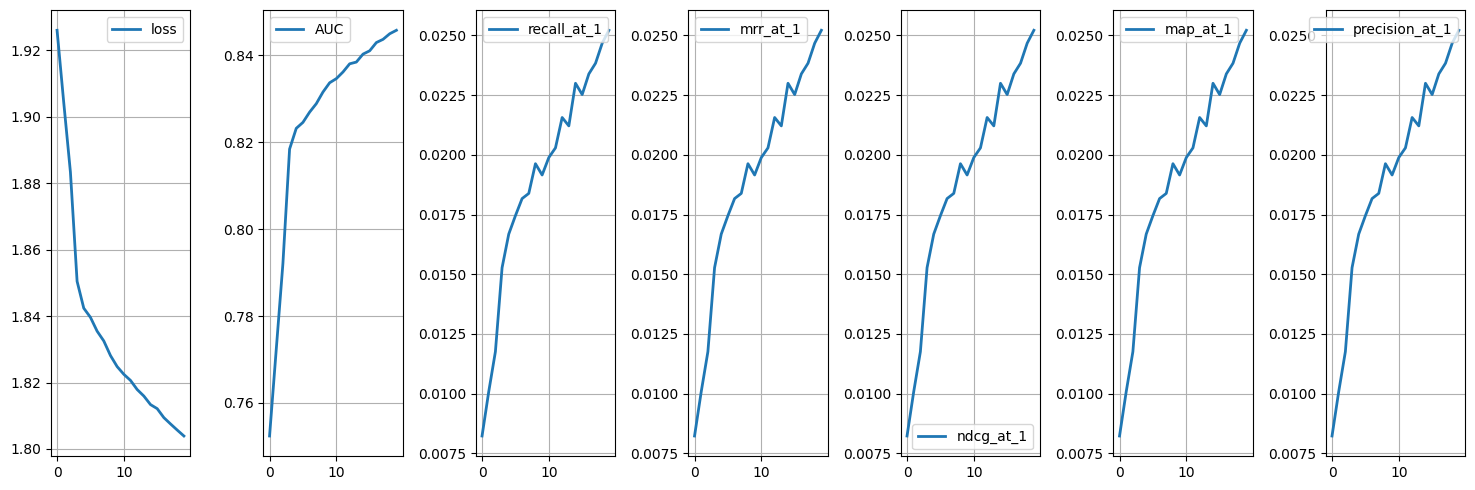

In [49]:
# training graph #optional
metrics = pd.DataFrame(history.history)[list(history.history.keys())[:-27]]
f, axs = plt.subplots(1, len(metrics.columns), figsize=(15,5))
for i, metric in enumerate(metrics.columns):
    axs[i].plot(range(0, len(metrics) ), list(metrics[metric].values), label=metric, linewidth=2)
    axs[i].legend()
    axs[i].grid()
plt.tight_layout()
plt.show()

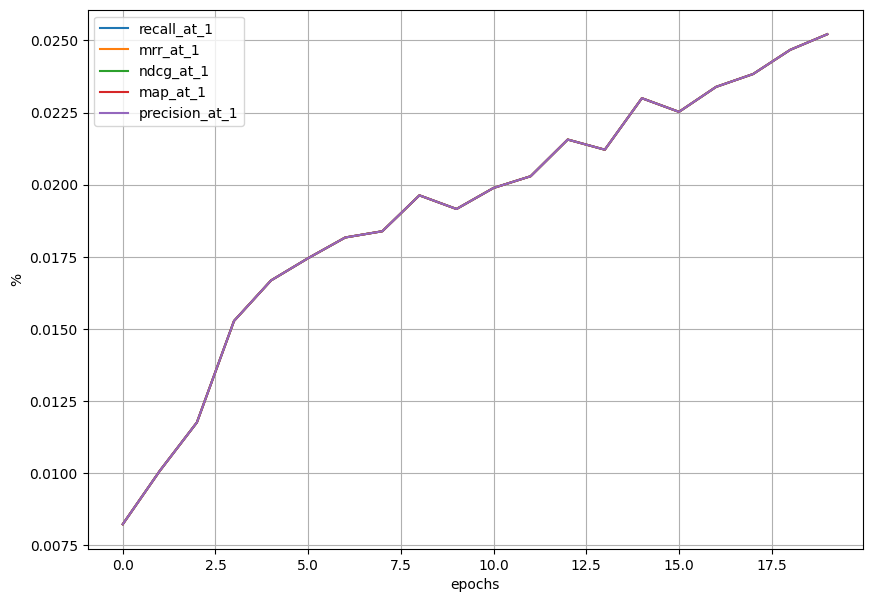

In [50]:
pd.DataFrame(history.history).iloc[:,2:7].plot(figsize=(10,7), xlabel="epochs", ylabel="%")
plt.grid()
plt.show()

In [51]:
# save model training #optional

In [52]:
XModel4Rec.save("Data/XModel4Rec01")

  (_feature_shapes): Dict(
    (ItemID_list): TensorShape([256, None, 1])
    (Category_list): TensorShape([256, None, 1])
    (binaryRating_list): TensorShape([256, None, 1])
    (DTPSequence_list): TensorShape([256, None, 1])
    (itemCountSession): TensorShape([256, 1])
  )
  (_feature_dtypes): Dict(
    (ItemID_list): tf.int64
    (Category_list): tf.int64
    (binaryRating_list): tf.int64
    (DTPSequence_list): tf.int64
    (itemCountSession): tf.float32
  )
), because it is not built.


INFO:tensorflow:Assets written to: Data/XModel4Rec01\assets


INFO:tensorflow:Assets written to: Data/XModel4Rec01\assets


In [54]:
metrics = pd.DataFrame(history.history)
metrics.to_csv(f"Data/{datasetName}/{EPOCHS}Epochs_history_{datasetName}_{blockT1.name}.csv", index=False)
metrics

,loss,AUC,recall_at_1,mrr_at_1,ndcg_at_1,map_at_1,precision_at_1,recall_at_10,mrr_at_10,ndcg_at_10,...,ndcg_at_40,map_at_40,precision_at_40,recall_at_50,mrr_at_50,ndcg_at_50,map_at_50,precision_at_50,regularization_loss,loss_batch
0,1.926055,0.752397,0.008225,0.008225,0.008225,0.008225,0.008225,0.069036,0.021882,0.032701,...,0.066511,0.028975,0.005570,0.266539,0.029941,0.074418,0.029941,0.005331,0.0,1.904004
1,1.904309,0.772272,0.010079,0.010079,0.010079,0.010079,0.010079,0.079994,0.025883,0.038318,...,0.076114,0.033847,0.006289,0.298953,0.034895,0.084682,0.034895,0.005979,0.0,1.898396
2,1.883367,0.792070,0.011756,0.011756,0.011756,0.011756,0.011756,0.099516,0.031656,0.047258,...,0.090385,0.040876,0.007350,0.344300,0.041989,0.099480,0.041989,0.006886,0.0,1.844434
3,1.850486,0.818423,0.015274,0.015274,0.015274,0.015274,0.015274,0.124719,0.039984,0.059445,...,0.110014,0.050948,0.008783,0.403109,0.052093,0.119376,0.052093,0.008062,0.0,1.833770
4,1.842388,0.823195,0.016681,0.016681,0.016681,0.016681,0.016681,0.131768,0.042717,0.063179,...,0.114977,0.053973,0.009091,0.416110,0.055136,0.124464,0.055136,0.008322,0.0,1.828639
5,1.839638,0.824565,0.017452,0.017452,0.017452,0.017452,0.017452,0.133946,0.043604,0.064343,...,0.116464,0.054960,0.009175,0.419127,0.056114,0.125888,0.056114,0.008383,0.0,1.823186
6,1.835468,0.826924,0.018169,0.018169,0.018169,0.018169,0.018169,0.136854,0.045099,0.066191,...,0.118983,0.056594,0.009325,0.426743,0.057783,0.128698,0.057783,0.008535,0.0,1.819947
7,1.832517,0.828866,0.018385,0.018385,0.018385,0.018385,0.018385,0.141792,0.046155,0.068119,...,0.120883,0.057619,0.009451,0.431438,0.058800,0.130537,0.058800,0.008629,0.0,1.818478
8,1.828130,0.831546,0.019630,0.019630,0.019630,0.019630,0.019630,0.144511,0.047579,0.069832,...,0.123457,0.059288,0.009600,0.437336,0.060469,0.133101,0.060469,0.008747,0.0,1.814669
9,1.824798,0.833680,0.019156,0.019156,0.019156,0.019156,0.019156,0.147447,0.048357,0.071144,...,0.125366,0.060167,0.009749,0.444168,0.061367,0.135170,0.061367,0.008883,0.0,1.812163


# Model Validation steps --------------------------------

In [55]:
testFlow.tail()

,UserID,ItemID_list,Category_list,binaryRating_list,DTPSequence_list,itemCountSession
8364,2060099,"[865, 162, 80, 144, 66, 55, 83, 14, 9, 125]","[3, 3, 7, 3, 3, 3, 3, 3, 3, 5]","[4, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 3, 3, 4, 4, 4, 4, 4, 3]",0.017544
8365,2061042,"[69, 34, 72, 244, 28, 314, 29, 24, 39, 9]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 4, 4, 4, 4, 4, 4, 4, 4, 4]",0.017544
8366,2061195,"[105, 48, 43, 660, 149, 276, 311, 63, 46, 291]","[5, 5, 3, 3, 3, 5, 5, 3, 3, 3]","[3, 3, 3, 4, 4, 4, 4, 4, 4, 4]","[3, 4, 3, 4, 4, 3, 4, 3, 4, 4]",0.017544
8367,2062388,"[323, 582, 137, 208, 57, 79, 147, 350, 4, 228]","[7, 5, 4, 4, 3, 3, 6, 4, 3, 4]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 4, 3, 4, 3, 3, 3, 3]",0.017544
8368,2062618,"[204, 5, 133, 31, 221, 35, 274, 107, 83, 8]","[5, 3, 3, 5, 4, 5, 6, 4, 3, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 4, 3, 3, 3, 3, 3, 3, 4]",0.017544


In [56]:
%%time
validation = XModel4Rec.evaluate(testFlow, batch_size=BATCH_SIZE_TEST, pre=computeLastPosition, return_dict=True)

9/9 [==============================] - 17s 62ms/step - loss: 1.8040 - AUC: 0.8438 - recall_at_1: 0.0268 - mrr_at_1: 0.0268 - ndcg_at_1: 0.0268 - map_at_1: 0.0268 - precision_at_1: 0.0268 - recall_at_10: 0.1707 - mrr_at_10: 0.0595 - ndcg_at_10: 0.0851 - map_at_10: 0.0595 - precision_at_10: 0.0171 - recall_at_20: 0.2823 - mrr_at_20: 0.0670 - ndcg_at_20: 0.1130 - map_at_20: 0.0670 - precision_at_20: 0.0141 - recall_at_30: 0.3583 - mrr_at_30: 0.0701 - ndcg_at_30: 0.1292 - map_at_30: 0.0701 - precision_at_30: 0.0119 - recall_at_40: 0.4227 - mrr_at_40: 0.0719 - ndcg_at_40: 0.1416 - map_at_40: 0.0719 - precision_at_40: 0.0106 - recall_at_50: 0.4777 - mrr_at_50: 0.0731 - ndcg_at_50: 0.1516 - map_at_50: 0.0731 - precision_at_50: 0.0096 - regularization_loss: 0.0000e+00 - loss_batch: 1.8008
CPU times: total: 27.6 s
Wall time: 31.4 s


In [57]:
validation

{'loss': 1.8039909601211548,
 'AUC': 0.8437840938568115,
 'recall_at_1': 0.026645954698324203,
 'mrr_at_1': 0.026645954698324203,
 'ndcg_at_1': 0.026645954698324203,
 'map_at_1': 0.026645954698324203,
 'precision_at_1': 0.026645954698324203,
 'recall_at_10': 0.1736169159412384,
 'mrr_at_10': 0.06068389490246773,
 'ndcg_at_10': 0.0867299735546112,
 'map_at_10': 0.06068389490246773,
 'precision_at_10': 0.01736169308423996,
 'recall_at_20': 0.2850997745990753,
 'mrr_at_20': 0.0682477205991745,
 'ndcg_at_20': 0.11469929665327072,
 'map_at_20': 0.0682477205991745,
 'precision_at_20': 0.014254989102482796,
 'recall_at_30': 0.3630063235759735,
 'mrr_at_30': 0.07138370722532272,
 'ndcg_at_30': 0.13129067420959473,
 'map_at_30': 0.07138370722532272,
 'precision_at_30': 0.012100210413336754,
 'recall_at_40': 0.42872506380081177,
 'mrr_at_40': 0.07325287163257599,
 'ndcg_at_40': 0.14398136734962463,
 'map_at_40': 0.07325287163257599,
 'precision_at_40': 0.010718125849962234,
 'recall_at_50': 0.48

# Model Prediction steps --------------------------------

In [58]:
%%time
result = XModel4Rec.predict(trainFlow, batch_size=BATCH_SIZE_TEST, pre=computeLastPosition)
result.shape

CPU times: total: 22 s
Wall time: 25.1 s


(8369, 897)

In [59]:
itemCatIDs = Dataset("categories/unique.ItemID.parquet").compute()
spectrum = pd.DataFrame(np.transpose(result), columns=testFlow.to_ddf(['UserID']).compute().UserID.values)
spectrum = spectrum[spectrum.index > 2]
spectrum.index = [itemCatIDs.ItemID[x-3] for x in spectrum.index]
spectrum = spectrum.sort_index()
#normalization
#spectrum = ((spectrum - spectrum.min())/(spectrum.max() - spectrum.min()))
spectrum

,1000004,1000010,1000021,1000023,1000024,1000025,1000027,1000029,1000031,1000036,...,2056982,2058021,2058374,2058533,2060068,2060099,2061042,2061195,2062388,2062618
100001,-1.605104,1.785806,-1.217429,-2.677846,-2.056448,2.281199,-2.329027,-1.632775,-1.700621,-0.561383,...,-0.879135,2.650286,-1.995388,-1.257710,3.143716,2.597871,-1.695679,-1.944999,-1.182451,-1.301054
100003,-1.444484,-1.157456,-1.848470,-0.526156,-1.490865,-0.855958,-1.340815,-1.748618,-1.209954,-1.541451,...,-1.597396,-0.902530,-1.219816,-1.525578,-0.264273,-0.888251,-1.188466,-1.554316,-1.753557,-1.503662
100005,-1.637562,-1.001781,-2.082441,-0.469240,-1.206501,-0.694293,-1.841180,-1.935738,-1.408875,-1.788994,...,-1.943300,-0.873711,-1.726839,-1.686637,0.213611,-0.765141,-1.468399,-1.492408,-2.337653,-1.916366
100007,-2.090900,-0.398048,-1.985163,-0.889457,-1.709177,-0.234338,-2.049195,-1.897294,-1.264947,-1.908239,...,-2.052816,-0.513539,-2.174625,-1.320433,-0.122037,-0.276641,-1.340936,-1.714447,-1.929254,-1.786958
100008,-1.142564,-0.037502,-1.820472,-1.000442,-1.204571,0.840765,-0.651506,-1.775651,-1.387555,-0.737847,...,-0.990604,0.616113,-1.339671,-1.887922,1.530638,0.667117,-1.182800,-1.364369,-1.532906,-1.637403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196920,-1.239963,-1.664641,-1.051786,-1.208810,-1.139470,-1.513673,-0.987131,-1.229449,-1.372784,-1.140951,...,-1.664223,-1.556931,-1.176375,-1.656675,-1.247211,-1.551926,-1.499822,-1.057498,-1.344493,-1.005450
196946,-1.602477,-1.482827,-1.166276,-1.303438,-1.447859,-1.260251,-1.449450,-1.314284,-1.393679,-1.618577,...,-1.248855,-1.269556,-1.356048,-1.529471,-0.831571,-1.039998,-1.287118,-1.178932,-1.633943,-1.103494
197673,-0.903266,-1.379136,-1.497492,0.245421,-0.639883,-1.305964,-0.781094,-1.176131,-0.697298,-1.618492,...,-1.209382,-1.677536,-0.940540,-1.092090,-1.246686,-1.579953,-0.775298,-0.925023,-1.663626,-1.407253
197934,-1.044387,-1.440569,-1.188900,-0.420589,-0.682626,-1.553991,-0.732472,-1.125723,-0.799558,-1.636812,...,-0.959871,-1.577845,-0.829821,-1.035566,-1.092239,-1.390784,-0.601873,-0.588636,-1.342494,-0.874231


In [61]:
# save spectum # optional
spectrum.to_csv(f"Data/{datasetName}/{EPOCHS}Epochs_spectrum_{datasetName}_{blockT1.name}.csv", index=True)

# X-Model4Rec Ranking steps ------------------------

In [62]:
from sklearn.metrics import ndcg_score

#useful dataframe functions
def getInteractedItemsByUser(userID, df, threshold=0):
    return df.loc[(df.UserID==userID) & (df.Rating>=threshold)]['ItemID'].unique()

def getNonInteractedItemsByUser(userID, df, threshold=0):
    interactedItems = getInteractedItemsByUser(userID, df, threshold=threshold) 
    nonInteractedItems = (set(df.ItemID.unique()) - set(interactedItems))  # all items (-) iteracted items
    return list(nonInteractedItems)

def combineFeatures(row={}, features=[]):
    combinedFeatures = ''.join(str(row[feature])+' ' for feature in features)  
    return combinedFeatures.strip().lower()

def ajust5StarsRating(rating): # 5-star ratings {0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5}
    if rating < 0.5:
        return 0.5
    elif rating > 5:
        return 5.0
    else:
        decimal = round(rating - int(rating), 1)
        if decimal >= 0.8:
            rating = int(rating) + 1.0
        elif decimal >= 0.3:
            rating = int(rating) + 0.5
        else:
            rating = int(rating)
        return round(float(rating),1)

# common model
class Model:
    _ModelName = 'Model'
    _recommendation = pd.NA  # _recommendation['UserID', 'Items', 'Weights', 'NextItem'] dtype [int, str(list), str(list), int]

    def __call__(self, testDF, addName='')->bool:
        try:
            # create the output recommendation space 
            self._recommendation = pd.DataFrame(testDF.UserID.unique(), columns=['UserID'])    
            # add NextItem for evaluate
            self._recommendation = pd.merge(self._recommendation, testDF[['UserID', 'ItemID']], on=['UserID'], how='left')\
                                        .rename(columns={'ItemID': 'NextItem'})
            # fields Items and Weights to be filled by method recommender()
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA  
            self._ModelName += addName
            print(self._ModelName, 'was created for', len(self._recommendation), 'user next item')
            return True
        except:
            print(self._ModelName + addName, 'was not created')
        return False
    
    def getName(self)->str:
        return self._ModelName
    
    def getRecommendations(self)->pd.DataFrame:
        return self._recommendation
    
    def getRecommendationByUser(self, userID=0, topN=10)->set:
        try:
            if (topN not in range(1, 51) or int(userID)<=0):
                print(self._ModelName, 'need top-N between 1-training:50 and a valid user ID')
                return {'nop': -1}
            listItems = eval(self._recommendation.loc[self._recommendation.UserID==userID]['Items'].values[0])[:topN]              
            return {"Name": self._ModelName, "UserID": userID, "Top-"+str(topN): listItems}
        except:
            print('Dataset inconsistency, need to run recommender method first.')
        return {'nop': -1}
    
    # Evaluation: 1 and position>=0 if matched between set of items recomendation and set of itemsID test(here = |1|) or
    #             0 and position=-1 if not matched, for that user.
    def _hitTopN(self, nextItemID, recommendation, topN=10)->tuple:
        for item in list(enumerate(recommendation))[:topN]: # (0, itemID0) (1, itemID1)... topN
            if item[1]==nextItemID:
                return 1, item[0]
        return 0, -100

    # processing global average for Precision@topN, Recall@topN, F1-Score@topN
    def _evaluateTopN(self, topN=10)->tuple:
        hitSumP, hitSumR, hitSumRR, hitSumAP, f1Score, hitSumnDCG = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        totalUsers = float(len(self._recommendation))
        relevance = np.asarray([np.arange(1, topN+1)[::-1]])  # inverse positions relevance
        for index, row in  self._recommendation.iterrows():   # for each user do
            hit, position = self._hitTopN(row.NextItem, eval(row.Items), topN)
            # Precision
            hitSumP += hit * (1/topN)
            # Recall
            hitSumR += hit  #hitSum += hit*(1/len(user Test set)) here = |1|
            # MAP
            hitSumAP += hit * (1/(position + 1)) # here = |1|  ????  MAP=MRR where |1|
            # MRR
            hitSumRR += hit * (1/(position + 1)) # here = |1|
            # nDGC      
            if hit==1:
                if topN==1:
                    hitSumnDCG += 1
                else:
                    scores = np.repeat(0, topN)
                    scores[position] = 1 
                    scores = np.asarray([scores])
                    hitSumnDCG += ndcg_score(relevance, scores, k=topN)
            
        precision = float(hitSumP/totalUsers)
        recall    = float(hitSumR/totalUsers)
        MAP       = float(hitSumAP/totalUsers)  
        MRR       = float(hitSumRR/totalUsers)
        nDCG      = float(hitSumnDCG/totalUsers)
        if (precision + recall) > 0:  # avoid division by zero
            f1Score = float(2 * (precision * recall)/(precision + recall))
        return round(precision, 6), round(recall, 6), round(f1Score, 6), round(MAP, 6), round(MRR, 6), round(nDCG, 6)
    
    def evaluate(self, topN=10)->set:
        try:
            if (topN not in range(1, 51)):
                print(self._ModelName, 'need run recommender method and top-N between 1-training:50')
                return {'nop': -1}
            print('processing evaluate', "Top-"+str(topN), '...', end='')
            precision, recall, f1Score, MAP, MRR, nDCG = self._evaluateTopN(topN)
            result = {"Name":self._ModelName, "P@"+str(topN):precision, "R@"+str(topN):recall, "F1@"+str(topN):f1Score, \
                      "MAP@"+str(topN):MAP, "MRR@"+str(topN):MRR, "NDCG@"+str(topN):nDCG}
            print(result)
            return result
        except:
            print('Evaluator inconsistency, need to run recommender method first.')
        return {'nop': -1}
    
    #Method to be rewritten by inheritance to fill _recommendation
    def recommender(self, topN=10)->bool:
        print('This recommender needs to be redefined with the heuristic to generate recommendation.')
        return False   

In [63]:
# built X-Model4Rec-eXtensible Model for Recommendation

In [64]:
class XModel4RecRanking(Model):
    _ModelName = 'X-Model4Rec'
    
    def __init__(self, xDF, yDF, spectrum, addName=''):
        try:
            if (not set(['UserID', 'ItemID', 'Rating']).issubset(xDF.columns) or not set(['UserID','ItemID']).issubset(yDF.columns)):
                print("dataset inconsistency, need columns as ['UserID', 'ItemID', 'Rating']")
                return None
            self._train = xDF[['UserID', 'ItemID', 'Rating']]
            self._recommendation, self._matrixFactorization, self._model, self._indexItemID = pd.NA, pd.NA, pd.NA, pd.NA
            self._spectrum = spectrum
            self.__call__(yDF, addName)
            return
        except:
            print('dataset inconsistency')
            return None      

    def getMatrixFactorization(self)->pd.DataFrame:
        return self._matrixFactorization
    
    def _itemMoreSimilarFromItemID(self, itemID, topN=50)-> (list, list):
        index = self._indexItemID[self._indexItemID.values==itemID].index[0]
        distances, suggestions = self._model.kneighbors( self._matrixFactorization.iloc[index, :].values.reshape(1, -1))
        return self._matrixFactorization.index[suggestions[0].tolist()[1:topN+1]], distances[0].tolist()[1:topN+1]
    
    def _computeNearestNeighbors(self, n_neighbors=50):
        #new spectrum
        trainDFplus = self._train.copy()
        trainDFplus = trainDFplus.drop_duplicates(['UserID', 'ItemID'], keep='last')
        #for index, row in trainDFplus.iterrows():
        #         ajust5StarsRating(trainDFplus.Rating[index] * (spectrum[row.UserID][row.ItemID])*1000)
        #    trainDFplus.at[index, 'Rating'] =  self._spectrum[row.UserID][row.ItemID]
        #trainDFplus.Rating.min(), trainDFplus.Rating.max()      
        # pivoting treatment        
        self._matrixFactorization = trainDFplus.pivot(columns='UserID', index='ItemID', values='Rating').fillna(0)
        # sparsivity treatment
        pivotSparse = csr_matrix(self._matrixFactorization)
        self._model = NearestNeighbors(algorithm='auto', metric='cosine', n_neighbors=n_neighbors)
        self._model.fit(pivotSparse)
        
        self._indexItemID = self._matrixFactorization.reset_index().rename(columns={'index': 'ItemID'})['ItemID']
        return    
        
    def recommender(self, topN=50, plus='')->bool:
        try:
            if (topN not in range(1, 51)):
                self._recommendation, self._matrixFactorization, self._model, self._indexItemID = pd.NA, pd.NA, pd.NA, pd.NA
                print(self._ModelName, 'need top-N in 0-50')
                return False
            self._ModelName = self._ModelName+"+"+plus if len(plus)>0 else self._ModelName
            print(self._ModelName, 'processing recommender...')
            # produces a set of recommendations for each tested user
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA
            
            if plus=='NearestNeighbors':
                self._computeNearestNeighbors(topN) # -> _itemMoreSimilarFromItemID(itemID)
                for index, row in tqdm(self._recommendation.iterrows(), total=self._recommendation.shape[0]):
                    interactedItemsByUser = getInteractedItemsByUser(row.UserID, self._train, threshold=0)
                    similarItemsIDs, similarItemsVal = [], []
                    for interactedItem in list(interactedItemsByUser)[-10:]:  # sequential recommender
                        similarItemsIDsByUser, similarItemsValByUser = self._itemMoreSimilarFromItemID(interactedItem, 10*3) 
                        similarItemsIDs += list(similarItemsIDsByUser)
                        similarItemsVal += list(similarItemsValByUser)
                        
                    predictionsItemsByUser = pd.DataFrame({'ItemID': similarItemsIDs, 'Distance': similarItemsVal}) \
                                    .sort_values(by='Distance', ascending=True).drop_duplicates(subset=['ItemID'], keep='first')
                    predictionsItemsByUser = predictionsItemsByUser.reset_index(drop=True).head(topN)
                    self._recommendation.at[index, 'Items']   = str(list(predictionsItemsByUser.ItemID))
                    self._recommendation.at[index, 'Weights'] = str([1.0-x for x in list(predictionsItemsByUser.Distance)])                        
            else: 
                for index, row in tqdm(self._recommendation.iterrows(), total=self._recommendation.shape[0]):
                    predictionsItemsByUser = self._spectrum[row.UserID].sort_values(ascending = False) \
                                                    .reset_index().rename(columns={row.UserID: 'Weight', 'index': 'ItemID'})
                    #interactedItemsByUser = getInteractedItemsByUser(row.UserID, self._train, threshold=0)
                    # Removing items already seen
                    #predictionsItemsByUser.loc[predictionsItemsByUser.ItemID.apply(lambda x: x not in interactedItemsByUser)] # (-) iteracted items
                    predictionsItemsByUser = predictionsItemsByUser.sort_values('Weight', ascending=False).head(topN)            
                    self._recommendation.loc[index, 'Items'] = str(list(predictionsItemsByUser.ItemID))
                    self._recommendation.loc[index, 'Weights'] = str(list(predictionsItemsByUser.Weight))
            return True
        except ValueError:
            self._recommendation, self._matrixFactorization, self._model, self._indexItemID = pd.NA, pd.NA, pd.NA, pd.NA
            print('recommender inconsistency', ValueError)
        return False

# Test Area

In [65]:
%%time
mX = XModel4RecRanking(trainDF0, testDF0, spectrum)
mX.recommender()

X-Model4Rec was created for 8369 user next item
X-Model4Rec processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 7.73 s
Wall time: 11 s


True

In [66]:
mX.getRecommendationByUser(userID=2056982, topN=10) # Example

{'Name': 'X-Model4Rec',
 'UserID': 2056982,
 'Top-10': [111395,
  111417,
  111458,
  155308,
  111422,
  111433,
  111415,
  162497,
  111475,
  111429]}

In [67]:
mX.evaluate()

processing evaluate Top-10 ...{'Name': 'X-Model4Rec', 'P@10': 0.016764, 'R@10': 0.167642, 'F1@10': 0.03048, 'MAP@10': 0.058046, 'MRR@10': 0.058046, 'NDCG@10': 0.142104}


{'Name': 'X-Model4Rec',
 'P@10': 0.016764,
 'R@10': 0.167642,
 'F1@10': 0.03048,
 'MAP@10': 0.058046,
 'MRR@10': 0.058046,
 'NDCG@10': 0.142104}